# Develop `baynes_sound_agrif` Figure Module

Development of functions for `nowcast.figures.research.baynes_sound_agrif` web site figure module.

**Goal:** A 4 panel figures showing  surface values of
temperature, salinity, diatoms biomass, and nitrate concentration
at 12:30 Pacific time.
Each panel to show all of the Baynes Sound sub-grid as well as
a fringe of the full domain on the 3 non-land sides.
Ideally the axes tick labels will be lon/lat with angled grid lines.

In [1]:
from pathlib import Path
from types import SimpleNamespace

import arrow
import cmocean
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy
from salishsea_tools import viz_tools
import xarray

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_prep_plot_data()` Function

In [39]:
def _prep_plot_data(ss_phys_url, bs_phys_path, ss_bio_url, bs_bio_path, run_date, ss_grid_url, bs_grid_path):
    ss_phys = xarray.open_dataset(ss_phys_url)
    ss_bio = xarray.open_dataset(ss_bio_url)
    for dataset in (ss_phys, ss_bio):
        shared.localize_time(dataset, time_coord='time')
        
    bs_phys = xarray.open_dataset(bs_phys_path)
    bs_bio = xarray.open_dataset(bs_bio_path)
    for dataset in (bs_phys, bs_bio):
        shared.localize_time(dataset, time_coord='time_counter')
        
    ss_grid = xarray.open_dataset(ss_grid_url, mask_and_scale=False)
    ss_water_mask = ss_grid.bathymetry!=0
    bs_grid = xarray.open_dataset(bs_grid_path, mask_and_scale=False)
    bs_water_mask = bs_grid.Bathymetry!=0

    ss_temperature = _get_data_array(ss_phys.temperature, ss_water_mask, run_date)
    bs_temperature = _get_data_array(bs_phys.votemper, bs_water_mask, run_date)
    bs_temperature.attrs['long_name'] = 'Conservative Temperature'
    ss_salinity = _get_data_array(ss_phys.salinity, ss_water_mask, run_date)
    bs_salinity = _get_data_array(bs_phys.vosaline, bs_water_mask, run_date)
    bs_salinity.attrs['long_name'] = 'Reference Salinity'
    ss_diatoms = _get_data_array(ss_bio.diatoms, ss_water_mask, run_date)
    bs_diatoms = _get_data_array(bs_bio.diatoms, bs_water_mask, run_date)
    ss_nitrate = _get_data_array(ss_bio.nitrate, ss_water_mask, run_date)
    bs_nitrate = _get_data_array(bs_bio.nitrate, bs_water_mask, run_date)
    return SimpleNamespace(
        ss_temperature=ss_temperature,
        bs_temperature=bs_temperature,
        ss_salinity=ss_salinity,
        bs_salinity=bs_salinity,
        ss_diatoms=ss_diatoms,
        bs_diatoms=bs_diatoms,
        ss_nitrate=ss_nitrate,
        bs_nitrate=bs_nitrate,
        run_date=run_date,
        ss_grid=ss_grid,
        bs_grid=bs_grid,
    )

In [38]:
def _get_data_array(ds_var, water_mask, run_date):
    exclude_bdy = slice(1, -2)
    try:
        return ds_var \
            .isel(deptht=0) \
            .sel(time_counter=run_date.format('YYYY-MM-DD 12:30')) \
            .where(water_mask)
    except ValueError:
        return ds_var \
            .isel(depth=0) \
            .sel(time=run_date.format('YYYY-MM-DD 12:30')) \
            .where(water_mask)

## `_prep_fig_axes()` Function

In [6]:
def _prep_fig_axes(figsize, plot_data, theme):
    fig, axs = plt.subplots(
        1, 4, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    map_params = SimpleNamespace(
        ll_lon=-124.68, ur_lon=-124.86,
        ll_lat=49.25, ur_lat=49.925,
        lon_0_offset=37.9,
        meridians=numpy.arange(-125.1, -124.3, 0.1),
        parallels=numpy.arange(49.2, 50, 0.1),
    )
    central_lon = (
        (map_params.ur_lon - map_params.ll_lon)/2 + map_params.ll_lon 
        + map_params.lon_0_offset
    )
    central_lat = (
        (map_params.ur_lat - map_params.ll_lat)/2 + map_params.ll_lat
    )
    for ax in axs:
        m = Basemap(
            ax=ax, projection='lcc',
            lon_0=central_lon, lat_0=central_lat,
            llcrnrlon=map_params.ll_lon, urcrnrlon=map_params.ur_lon,
            llcrnrlat=map_params.ll_lat, urcrnrlat=map_params.ur_lat,
        )
        # lon/lat grid
        m.drawmeridians(
            map_params.meridians, labels=(False, False, False, True),
            textcolor=theme.COLOURS['text']['axis'],
            fontproperties=theme.FONTS['axis small'],
        )
        m.drawparallels(
            map_params.parallels, labels=(True, False, False, False),
            textcolor=theme.COLOURS['text']['axis'],
            fontproperties=theme.FONTS['axis small'],)
    ss_x, ss_y = m(plot_data.ss_grid.longitude.values, plot_data.ss_grid.latitude.values)
    bs_x, bs_y = m(plot_data.bs_grid.nav_lon.values, plot_data.bs_grid.nav_lat.values)
    grids = SimpleNamespace(ss_x=ss_x, ss_y=ss_y, bs_x=bs_x, bs_y=bs_y)
    return fig, axs, grids

## `_plot_surface_fields()` Function

In [7]:
def _plot_surface_fields(axs, plot_data, grids, theme):
    vars = [
        (plot_data.ss_temperature, plot_data.bs_temperature, cmocean.cm.thermal),
        (plot_data.ss_salinity, plot_data.bs_salinity, cmocean.cm.haline),
        (plot_data.ss_diatoms, plot_data.bs_diatoms, cmocean.cm.algae),
        (plot_data.ss_nitrate, plot_data.bs_nitrate, cmocean.cm.matter),
    ]
    for i, (ss_var, bs_var, cmap) in enumerate(vars):
        _plot_surface_field(axs[i], ss_var, bs_var, cmap, grids, theme)

In [36]:
def _plot_surface_field(ax, ss_var, bs_var, cmap, grids, theme):
    cmap = plt.get_cmap(cmap)
    clevels = numpy.linspace(
        numpy.floor(bs_var.where(bs_var>0).min()),
        numpy.ceil(bs_var.where(bs_var>0).max()),
        20
    )
    ax.contourf(grids.ss_x, grids.ss_y, ss_var, cmap=cmap, levels=clevels, extend='max')
    contour_set = ax.contourf(grids.bs_x, grids.bs_y, bs_var, cmap=cmap, levels=clevels, extend='max')
#     ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
    ax.set_axis_bgcolor('burlywood')
    cbar = plt.colorbar(contour_set, ax=ax)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        f'{bs_var.attrs["long_name"]} [{bs_var.attrs["units"]}]',
        color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'],
    )
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [29]:
def make_figure(
    ss_phys_url, bs_phys_path, ss_bio_url, bs_bio_path,
    run_date,
    ss_grid_url, bs_grid_path,
    figsize=(22, 9),
    theme=nowcast.figures.website_theme):
    plot_data = _prep_plot_data(ss_phys_url, bs_phys_path, ss_bio_url, bs_bio_path, run_date, ss_grid_url, bs_grid_path)
    fig, axs, grids = _prep_fig_axes(figsize, plot_data, theme)
    _plot_surface_fields(axs, plot_data, grids, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


7.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


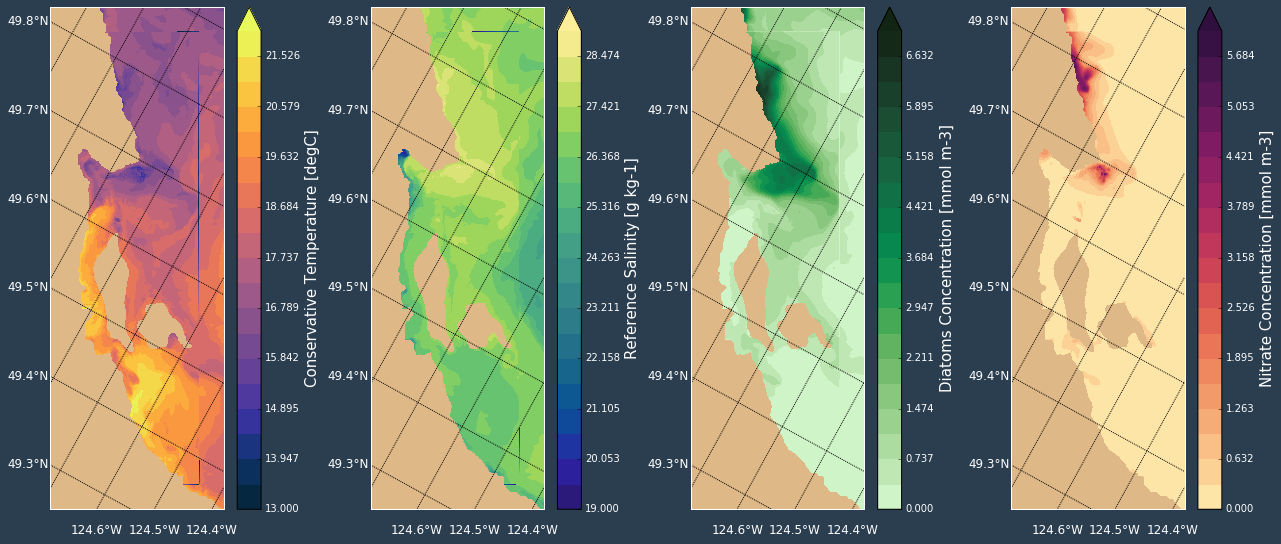

In [41]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
reload(website_theme)

results_archive = Path('/results/SalishSea/nowcast-green/')
agrif_results_archive = Path('/results/SalishSea/nowcast-agrif/')
run_date = arrow.get('2018-07-23')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

ss_phys_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02'
bs_phys_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
ss_bio_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bs_bio_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc'
ss_grid_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02'
bs_grid_path = Path('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')

fig = make_figure(ss_phys_url, bs_phys_path, ss_bio_url, bs_bio_path, run_date, ss_grid_url, bs_grid_path)

In [15]:
results_archive = Path('/results/SalishSea/nowcast-green/')
agrif_results_archive = Path('/results/SalishSea/nowcast-agrif/')
run_date = arrow.get('2018-07-17')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

ss_phys_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02'
bs_phys_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc'
ss_bio_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bs_bio_path = agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc'
ss_grid_url = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02'
bs_grid_path = Path('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')

plot_data = _prep_plot_data(ss_phys_url, bs_phys_path, ss_bio_url, bs_bio_path, run_date, ss_grid_url, bs_grid_path)

In [23]:
plot_data.bs_salinity.where(plot_data.bs_salinity>0).min()

<xarray.DataArray 'vosaline' ()>
array(22.06085205078125)
Coordinates:
    deptht         float32 0.5
    time_centered  datetime64[ns] 2018-07-17T19:30:00
    time_counter   datetime64[ns] 2018-07-17T12:30:00

In [24]:
plot_data.bs_nitrate.where(plot_data.bs_nitrate>0).min()

<xarray.DataArray 'nitrate' ()>
array(0.00035562983248382807)
Coordinates:
    deptht         float32 0.5
    time_centered  datetime64[ns] 2018-07-17T19:30:00
    time_counter   datetime64[ns] 2018-07-17T12:30:00

In [43]:
results_archive = Path('/results/SalishSea/nowcast-green/')
agrif_results_archive = Path('/results/SalishSea/nowcast-agrif/')
run_date = arrow.get('2018-07-17')
ddmmmyy = run_date.format('DDMMMYY').lower()
yyyymmdd = run_date.format('YYYYMMDD')

In [44]:
# phys = xarray.open_dataset(results_archive/ddmmmyy/f'SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc')
# shared.localize_time(phys, time_coord='time_counter')
phys = xarray.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')
shared.localize_time(phys)
phys

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 33648)
Coordinates:
  * time         (time) datetime64[ns] 2014-09-13T17:30:00 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
  * gridY        (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
Data variables:
    buoy_n2      (time, depth, gridY, gridX) float64 ...
    salinity     (time, depth, gridY, gridX) float64 ...
    temperature  (time, depth, gridY, gridX) float64 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             sallen@eoas.ubc.ca
    creator_name:              Salish Sea MEOPAR Project Contributors
    creator_url:               https://salishsea-meopar-docs.readthedocs.io/
    description:               ocean T grid variables
    d

In [45]:
bs_phys = xarray.open_dataset(agrif_results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_grid_T.nc')
shared.localize_time(bs_phys, time_coord='time_counter')
bs_phys

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2018-07-16T17:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float64 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 ...
    time_counter_bounds   (time_counter, axis_nbounds) float64 ...
    votemper              (time_counter, deptht, y, x) float64 ...
    vosal

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


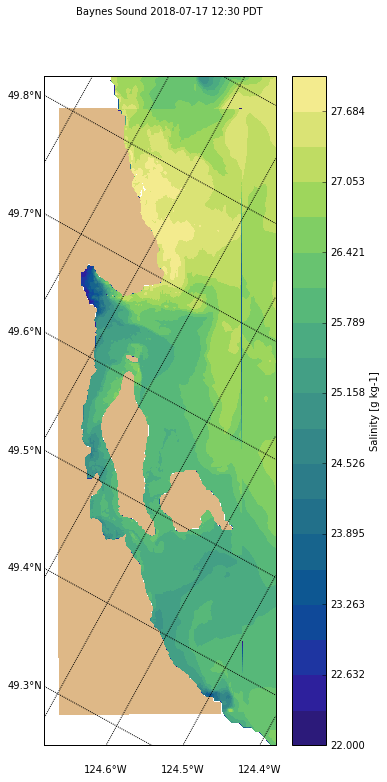

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
map_params = SimpleNamespace(
    ll_lon=-124.68, ur_lon=-124.86,
    ll_lat=49.25, ur_lat=49.925,
    lon_0_offset=37.9,
    meridians=numpy.arange(-125.1, -124.3, 0.1),
    parallels=numpy.arange(49.2, 50, 0.1),
)
central_lon = (
    (map_params.ur_lon - map_params.ll_lon)/2 + map_params.ll_lon 
    + map_params.lon_0_offset
)
central_lat = (
    (map_params.ur_lat - map_params.ll_lat)/2 + map_params.ll_lat
)
m = Basemap(
    ax=ax, projection='lcc',
    lon_0=central_lon, lat_0=central_lat,
    llcrnrlon=map_params.ll_lon, urcrnrlon=map_params.ur_lon,
    llcrnrlat=map_params.ll_lat, urcrnrlat=map_params.ur_lat,
)
# lon/lat grid
m.drawmeridians(map_params.meridians, labels=(False, False, False, True))
m.drawparallels(map_params.parallels, labels=(True, False, False, False))

grid = xarray.open_dataset(
    '/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc',
    mask_and_scale=False,
)
x, y = m(grid.nav_lon.values, grid.nav_lat.values)

fringe_grid = xarray.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02',
#     '/media/doug/warehouse/MEOPAR/grid/bathymetry_201702.nc',
    mask_and_scale=False,
)
fringe_x, fringe_y = m(fringe_grid.longitude.values, fringe_grid.latitude.values)

tracer = bs_phys.vosaline.isel(deptht=0, time_counter=19)
# fringe_tracer = phys.vosaline.isel(deptht=0, time_counter=19)
fringe_tracer = phys.salinity.isel(depth=0).sel(time=run_date.format('YYYY-MM-DD 12:30'))
ax.contourf(
    fringe_x, fringe_y, fringe_tracer,
    cmap=cmocean.cm.haline,
    levels=numpy.linspace(
        numpy.floor(tracer.where(tracer>0).min()),
        numpy.floor(tracer.where(tracer>0).max()),
        20
    ),
)
contour_set = ax.contourf(
    x, y, tracer,
    cmap=cmocean.cm.haline,
    levels=numpy.linspace(
        numpy.floor(tracer.where(tracer>0).min()),
        numpy.floor(tracer.where(tracer>0).max()),
        20
    ),
)

ax.contourf(x, y, grid.Bathymetry, [-0.01, 0.01], colors='burlywood')
# ax.contour(x, y, grid.Bathymetry, [-0.01, 0.01], colors='black')

# ax.set_axis_bgcolor('burlywood')

cbar = plt.colorbar(contour_set, ax=ax)
cbar.set_label(f'{tracer.long_name.title()} [{tracer.units}]')

fig.suptitle(
    f'Baynes Sound '
    f'{bs_phys.time_counter.dt.year.values[19]:04d}-{bs_phys.time_counter.dt.month.values[19]:02d}-{bs_phys.time_counter.dt.day.values[19]:02d} '
    f'{bs_phys.time_counter.dt.hour.values[19]:02d}:{bs_phys.time_counter.dt.minute.values[19]:02d} {bs_phys.attrs["tz_name"]}')

In [17]:
fringe_tracer

<xarray.DataArray 'salinity' (gridY: 898, gridX: 398)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
    time     datetime64[ns] 2014-09-14T12:30:00
    depth    float32 0.5
  * gridY    (gridY) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    _ChunkSizes:            [  1  40 898 398]
    colorBarMaximum:        34.0
    colorBarMinimum:        0.0
    coverage_content_type:  modelResult
    ioos_category:          salinity
    long_name:              salinity
    standard_name:          sea_water_reference_salinity
    units:                  g kg-1

In [6]:
bs_bio = xarray.open_dataset(results_archive/ddmmmyy/f'1_SalishSea_1h_{yyyymmdd}_{yyyymmdd}_ptrc_T.nc')
bs_bio

<xarray.Dataset>
Dimensions:                       (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat                       (y, x) float32 ...
    nav_lon                       (y, x) float32 ...
  * deptht                        (deptht) float32 0.5 1.5 2.50001 3.50003 ...
    time_centered                 (time_counter) datetime64[ns] ...
  * time_counter                  (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon                    (y, x, nvertex) float32 ...
    bounds_lat                    (y, x, nvertex) float32 ...
    area                          (y, x) float32 ...
    deptht_bounds                 (deptht, axis_nbounds) float32 ...
    nitrate                       (time_counter, deptht, y, x) float64 ...
    time_centered_bounds          (time_counter, axis_nbounds) float64 ...
    time_counter_bounds           (time_counter

In [8]:
mesh_mask = xarray.open_dataset('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/mesh_mask201702.nc')
mesh_mask

<xarray.Dataset>
Dimensions:  (x: 139, y: 394)
Dimensions without coordinates: x, y
Data variables:
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    mbathy   (y, x) float32 ...

In [9]:
mesh_mask.mbathy

<xarray.DataArray 'mbathy' (y: 394, x: 139)>
array([[  0.,   0.,   0., ...,  20.,  24.,  24.],
       [  0.,   0.,   0., ...,  20.,  24.,  24.],
       [  0.,   0.,   0., ...,  24.,  26.,  26.],
       ..., 
       [  0.,   0.,   0., ...,  34.,  34.,  34.],
       [  0.,   0.,   0., ...,  34.,  34.,  34.],
       [  0.,   0.,   0., ...,  34.,  34.,  34.]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    units:      count
    long_name:  fortran index of deepest water cell, T-grid

In [10]:
water = mesh_mask.mbathy!=0
water

<xarray.DataArray 'mbathy' (y: 394, x: 139)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)
Dimensions without coordinates: y, x

In [21]:
bathy = xarray.open_dataset('/media/doug/warehouse/MEOPAR/grid/subgrids/BaynesSound/bathymetry_201702_BS.nc')
bathy

<xarray.Dataset>
Dimensions:     (x: 139, y: 394)
Dimensions without coordinates: x, y
Data variables:
    Bathymetry  (y, x) float32 ...
    nav_lat     (y, x) float32 ...
    nav_lon     (y, x) float32 ...
Attributes:
    history:  Tue Oct 17 16:59:44 2017: ncks -4 -L4 -O subgrids/BaynesSound/b...
    NCO:      "4.6.3"

In [22]:
bathy.Bathymetry

<xarray.DataArray 'Bathymetry' (y: 394, x: 139)>
array([[   0.      ,    0.      ,    0.      , ...,   69.899307,   79.677513,
          81.5     ],
       [   0.      ,    0.      ,    0.      , ...,   70.181717,   82.107498,
          83.322487],
       [   0.      ,    0.      ,    0.      , ...,   79.272141,   86.967468,
          86.967468],
       ..., 
       [   0.      ,    0.      ,    0.      , ...,  272.456726,  269.081726,
         269.081726],
       [   0.      ,    0.      ,    0.      , ...,  266.495209,  264.16507 ,
         264.16507 ],
       [   0.      ,    0.      ,    0.      , ...,  266.495209,  263.      ,
         263.      ]], dtype=float32)
Dimensions without coordinates: y, x
Attributes:
    units:      metres
    long_name:  sea_floor_depth

In [23]:
water = bathy.Bathymetry!=0
water

<xarray.DataArray 'Bathymetry' (y: 394, x: 139)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)
Dimensions without coordinates: y, x

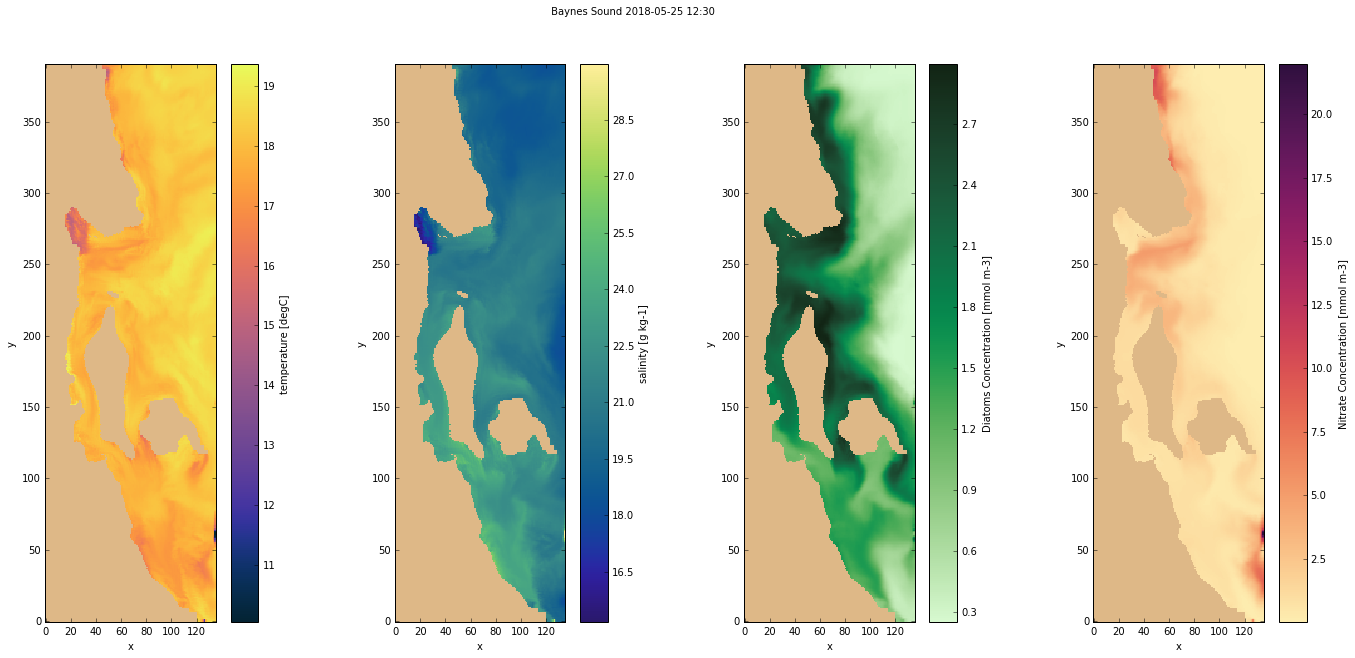

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(24, 10))
exclude_bdy = slice(1, -2)
vars = [
    {
        'dataset': bs_phys,
        'nemo var': 'votemper',
        'cmap': cmocean.cm.thermal,
    },
    {
        'dataset': bs_phys,
        'nemo var': 'vosaline',
        'cmap': cmocean.cm.haline,
    },
    {
        'dataset': bs_bio,
        'nemo var': 'diatoms',
        'cmap': cmocean.cm.algae,
    },
    {
        'dataset': bs_bio,
        'nemo var': 'nitrate',
        'cmap': cmocean.cm.matter,
    }
]
for i, var in enumerate(vars):
    cmap = plt.get_cmap(var['cmap'])
    cmap.set_bad('burlywood')
    ds_var = getattr(var['dataset'], var['nemo var'])
    mesh = ds_var.isel(deptht=0, time_counter=12) \
        .where(water) \
        .isel(y=exclude_bdy, x=exclude_bdy).plot(
            ax=axs[i], cmap=cmap,
    )
    mesh.colorbar.set_label(f'{ds_var.attrs["long_name"]} [{ds_var.attrs["units"]}]')
for ax in axs:
    viz_tools.set_aspect(ax)
    ax.set_title('')
fig.suptitle(f'Baynes Sound {bs_phys.time_counter.dt.year.values[0]}-{bs_phys.time_counter.dt.month.values[0]:02d}-{bs_phys.time_counter.dt.day.values[0]:02d} 12:30')

In [28]:
bs_phys.votemper

<xarray.DataArray 'votemper' (time_counter: 24, deptht: 40, y: 394, x: 139)>
[52575360 values with dtype=float64]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  20 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 20 s)
    cell_measures:       area: area

In [2]:
ds = xarray.open_dataset(
    '/results/SalishSea/nowcast-agrif/25may18/1_SalishSea_1h_20180525_20180525_grid_T.nc')
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 24, x: 139, y: 394)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.50001 3.50003 4.50007 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2018-05-25T00:30:00 ...
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    sossheig              (time_counter, y, x) float64 ...
    time_centered_bounds  (time_counter, axis_nbounds) float64 ...
    time_counter_bounds   (time_counter, axis_nbounds) float64 ...
    votemper              (time_counter, deptht, y, x) float64 ...
    vosal

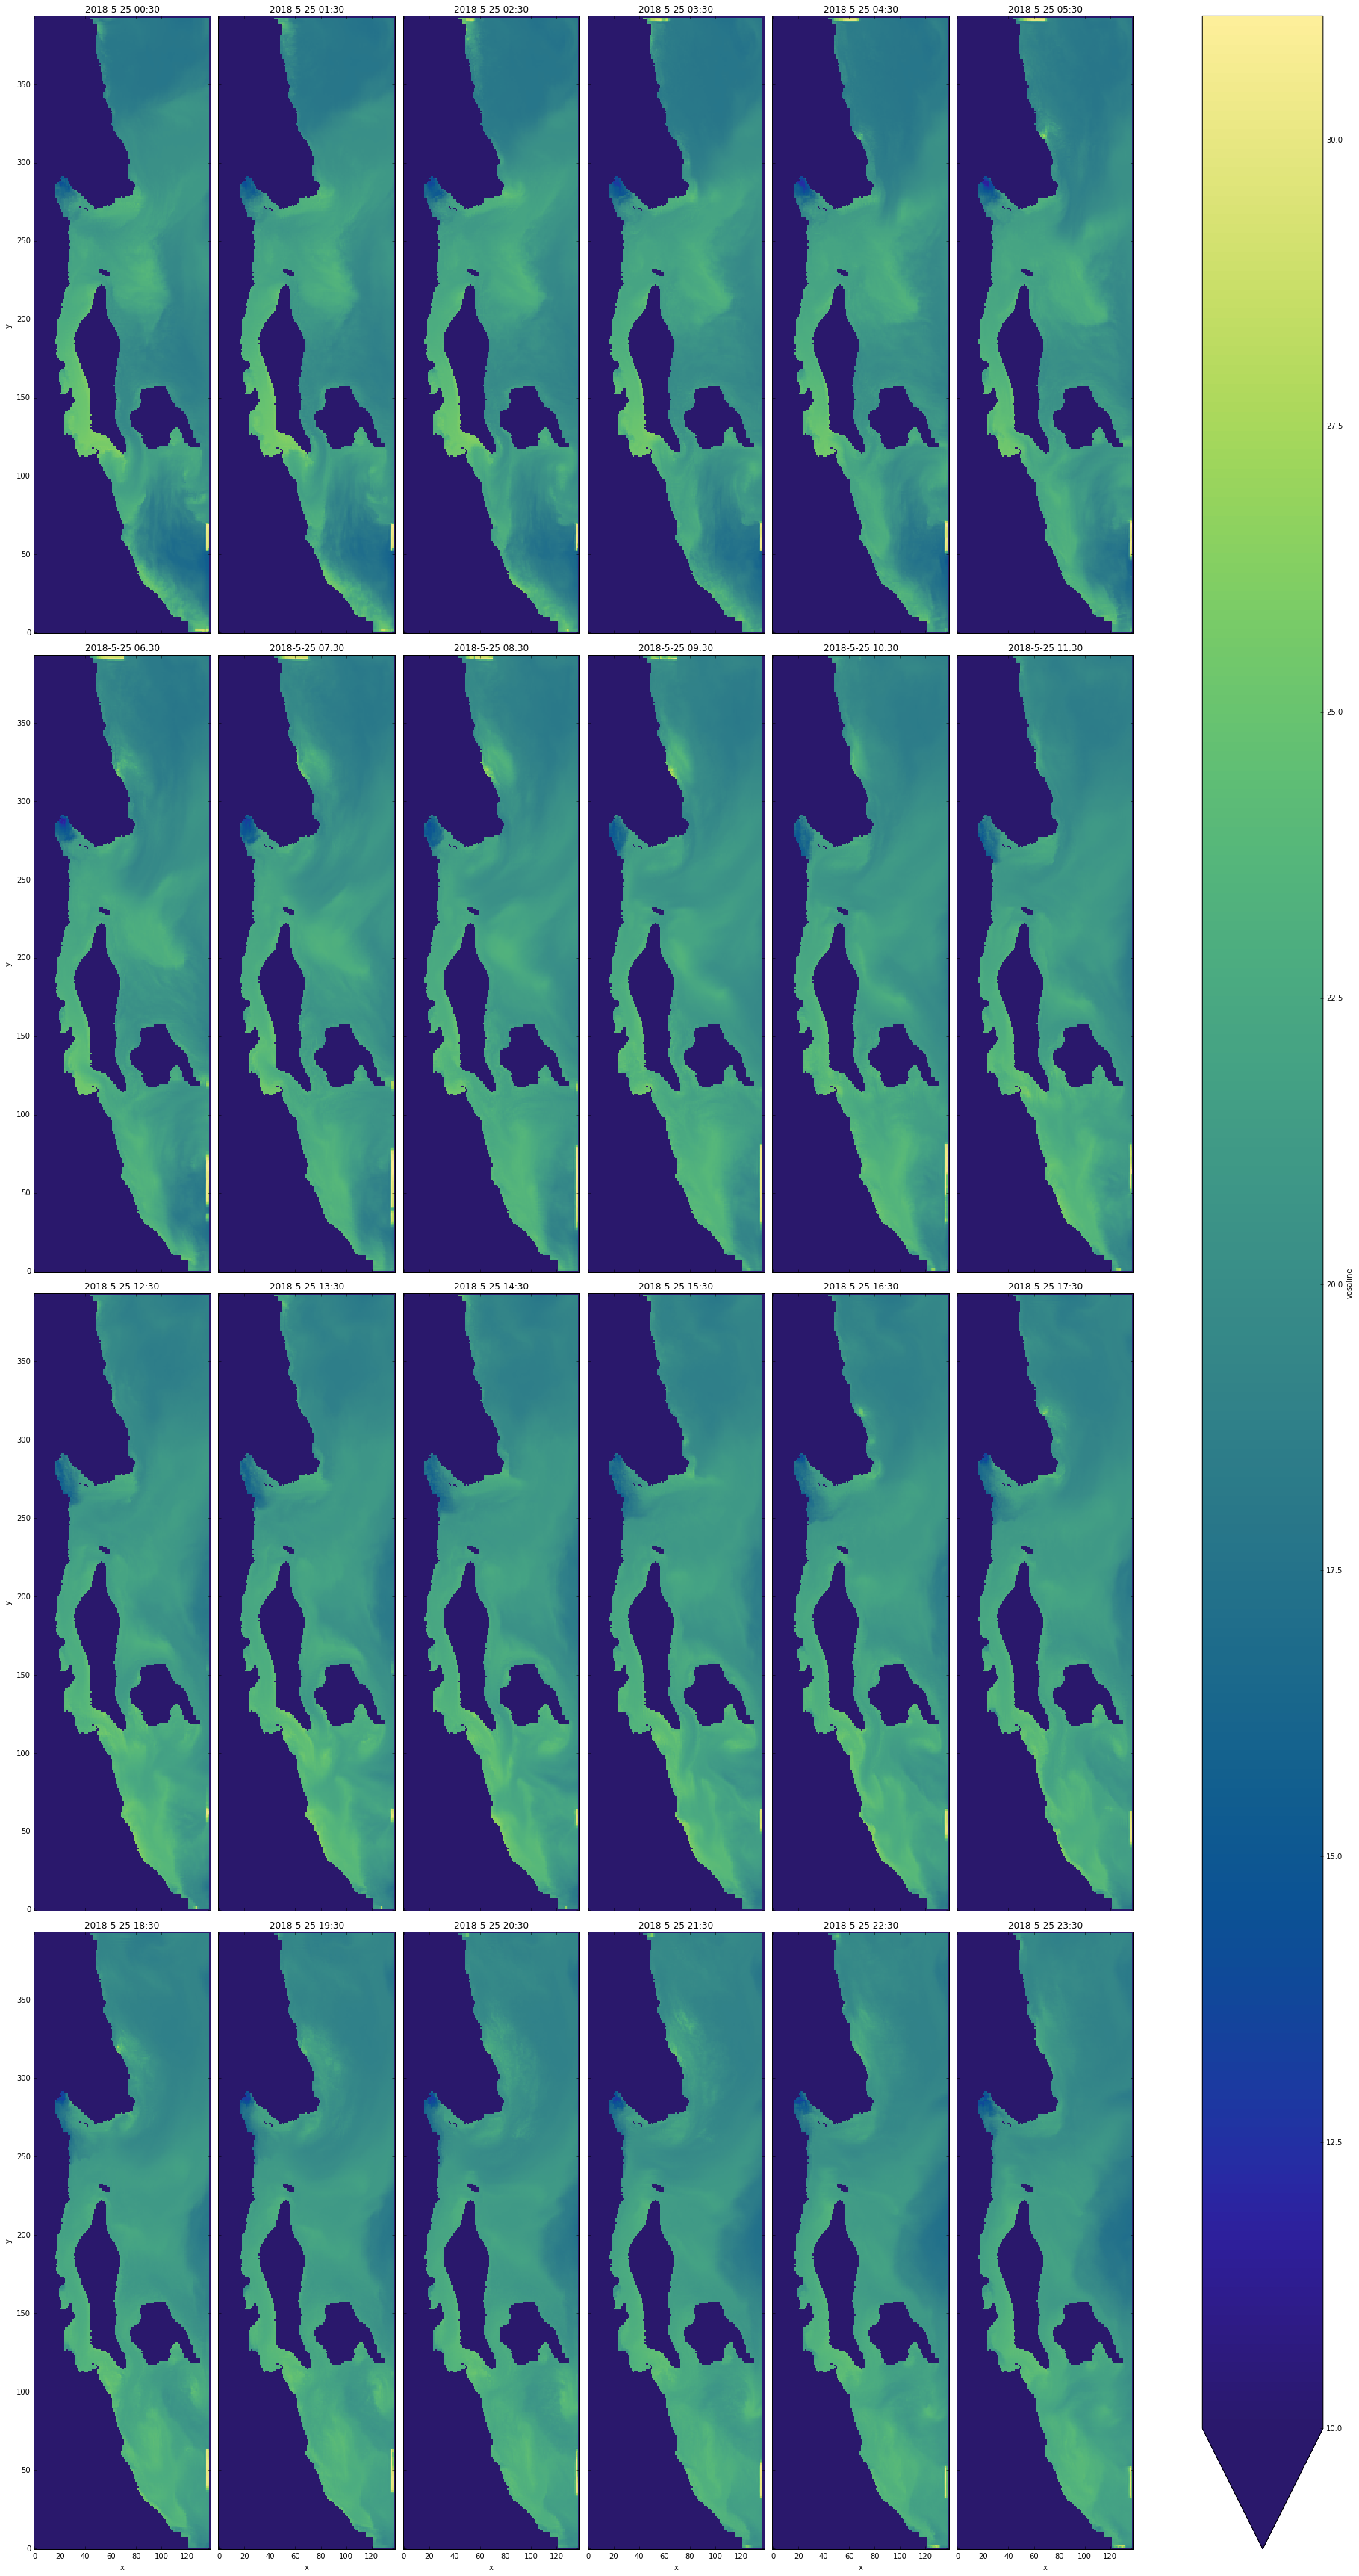

In [43]:
fg = ds.vosaline.isel(deptht=0).plot(
    x='x', y='y', col='time_counter', col_wrap=6, 
    aspect=139/394, size=12,
    cmap=cmocean.cm.haline, vmin=10,
)
date = f'{ds.time_counter.dt.year.values[0]}-{ds.time_counter.dt.month.values[0]}-{ds.time_counter.dt.day.values[0]}'
for i, ax in enumerate(fg.axes.flat):
    ax.set_title(f'{date} {ds.time_counter.dt.hour.values[i]:02d}:30')

In [16]:
ds.vosaline.max(), ds.vosaline.min()

(<xarray.DataArray 'vosaline' ()>
 array(31.651756286621094), <xarray.DataArray 'vosaline' ()>
 array(0.0))